In [12]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
# choose model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
all_surps = []
all_entrs = []
sentence =  "The man eat an apple and a pear"
sentence = sentence.lower().split(' ')

# create different versions of the sentence so that we incrementally increase the number of words in the sentence
sentences = ["[CLS][MASK]"]
devines = []
for num,i in enumerate(sentence):
    devines.append(i)
    if num >0:
        sentences.append("[CLS] "+ " ".join(sentence[0:num])+" [MASK]")

for num,sent in enumerate(sentences):
        # tokenize the sentence
        inputs = tokenizer(sent, return_tensors="pt")
        # tokenize also the next word and get only the middle part without the special caracters at the begining and end
        inputs2 = tokenizer(devines[num], return_tensors="pt")
        inputs22 = inputs2['input_ids'].detach().numpy()[0][1:-1]
        with torch.no_grad():
            logits = model(**inputs).logits
        mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        # getting prob distrib over all vocabulary
        next_token_logits = logits[0, mask_token_index]
        # softmax
        probs1 = F.softmax(next_token_logits, dim=-1)
        # get only the prob of the predicted word
        probs = probs1.detach().numpy()[0][inputs22]
        # Transform word prob into the surprisal
        surp = -np.log2(probs)
        # if word is form of multiple tokens: average surprisal over token
        if len(surp)>1:
            surp = [np.mean(surp,0)]
        all_surps.append(surp[0])
        # get entropy 
        entropy = -np.sum(probs1.detach().numpy()*np.log2(probs1.detach().numpy()))
        all_entrs.append(entropy)

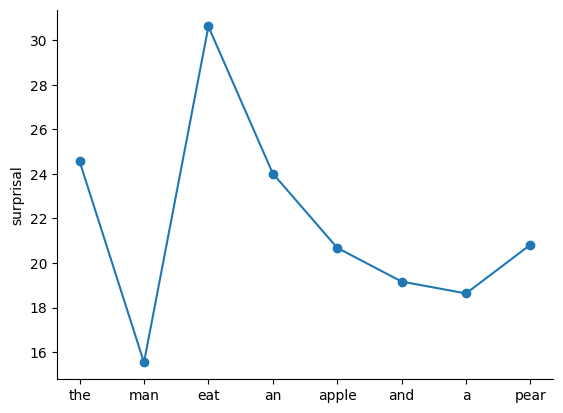

In [21]:
fig,ax = plt.subplots(1,1)
ax.plot(all_surps,'-o');
ax.set_xticks(np.arange(0, len(devines)))
ax.set_xticklabels(devines);
ax.set_ylabel('surprisal');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

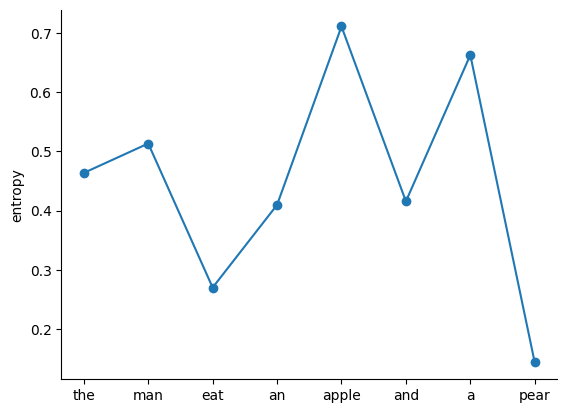

In [22]:
fig,ax = plt.subplots(1,1)
ax.plot(all_entrs,'-o');
ax.set_xticks(np.arange(0, len(devines)))
ax.set_xticklabels(devines);
ax.set_ylabel('entropy');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);